In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))
    ])

transform = transforms.ToTensor()

mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

data_loader = torch.utils.data.DataLoader(dataset=mnist_data,
                                          batch_size=64,
                                          shuffle=True)

mnist_data_valid = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

data_loader_valid = torch.utils.data.DataLoader(dataset=mnist_data_valid,
                                          batch_size=64,
                                          shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 98531850.17it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 110828631.13it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 27352512.81it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20137979.67it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
dataiter = iter(data_loader)

In [4]:
class Autoencoder_Linear(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128), # (N, 784) -> (N, 128)
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3) # -> N, 3
        )

        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Input [-1, +1] -> use nn.Tanh

In [5]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        # N, 1, 28, 28
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), # -> N, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(32, 64, 7) # -> N, 64, 1, 1
        )

        # N , 64, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # N, 16, 14, 14 (N,16,13,13 without output_padding)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # N, 1, 28, 28  (N,1,27,27)
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


# Note: nn.MaxPool2d -> use nn.MaxUnpool2d, or use different kernelsize, stride etc to compensate...
# Input [-1, +1] -> use nn.Tanh

In [6]:
# model = Autoencoder()
model = Autoencoder_Linear()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3,
                             weight_decay=1e-5)

In [7]:
# Point to training loop video
num_epochs = 10
outputs = []
noise_factor = 0.5
for epoch in range(num_epochs):
    for (img, _) in data_loader:
    # Añadir ruido gaussiano a las imágenes de entrada
        noisy_img = img + torch.randn(img.size()) * noise_factor
        noisy_img = torch.clamp(noisy_img, 0., 1.)  # Asegurar que las imágenes están en el rango [0, 1]

        # Reshape para Autoencoder_Linear
        img = img.reshape(-1, 28*28)
        noisy_img = noisy_img.reshape(-1, 28*28)

        # Paso hacia adelante
        recon = model(noisy_img)

        # Calcular la pérdida entre la imagen original y la reconstruida
        loss = criterion(recon, img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img, recon))

Epoch:1, Loss:0.0548
Epoch:2, Loss:0.0479
Epoch:3, Loss:0.0477
Epoch:4, Loss:0.0463
Epoch:5, Loss:0.0378
Epoch:6, Loss:0.0356
Epoch:7, Loss:0.0395
Epoch:8, Loss:0.0422
Epoch:9, Loss:0.0380
Epoch:10, Loss:0.0401


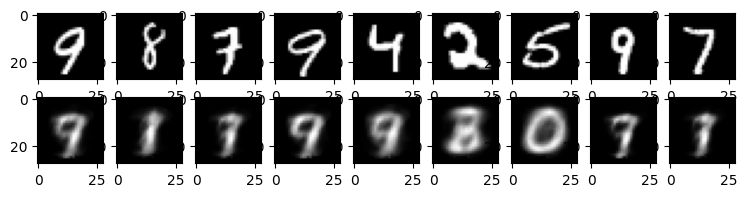

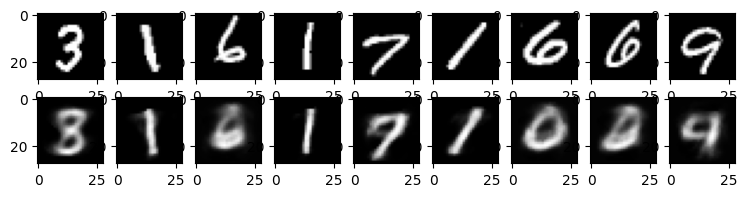

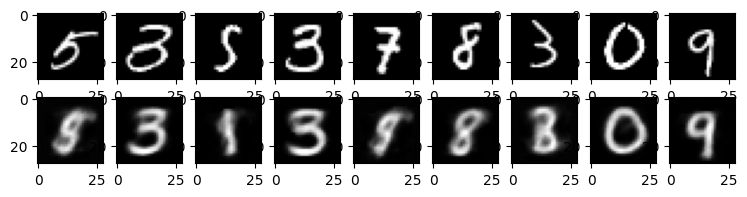

In [8]:
for k in range(0, num_epochs, 4):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])

    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1) # row_length + i + 1
        item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])

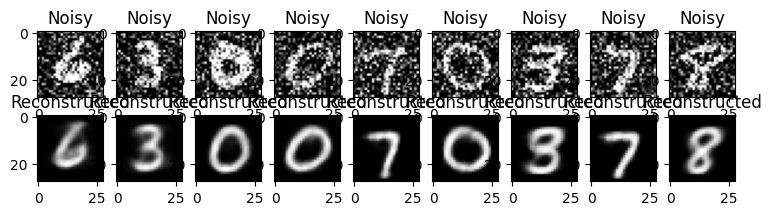

In [9]:
# Después del bucle de entrenamiento
model.eval()

# Obtener imágenes con ruido para la evaluación
for noisy_images, _ in data_loader_valid:
    # Añadir ruido gaussiano a las imágenes de entrada
    noisy_images = noisy_images + torch.randn(noisy_images.size()) * noise_factor
    noisy_images = torch.clamp(noisy_images, 0., 1.)  # Asegurar que las imágenes están en el rango [0, 1]

    plt.figure(figsize=(9, 2))
    plt.gray()

    for i, noisy_img in enumerate(noisy_images[:9]):
        with torch.no_grad():
            noisy_img = noisy_img.reshape(-1, 28*28)
            pred = model(noisy_img)
            recon = pred[0].detach().numpy()
            recon = recon.reshape(-1, 28, 28)

            plt.subplot(2, 9, i + 1)
            plt.imshow(noisy_img[0].reshape(28, 28), cmap='gray')
            plt.title('Noisy')

            plt.subplot(2, 9, i + 1 + 9)
            plt.imshow(recon[0], cmap='gray')
            plt.title('Reconstructed')

    plt.show()
    break  # Si deseas salir después de procesar el primer lote


Parte 2

Epoch:1, Loss:0.0012
Epoch:2, Loss:0.0012
Epoch:3, Loss:0.0011
Epoch:4, Loss:0.0011
Epoch:5, Loss:0.0011


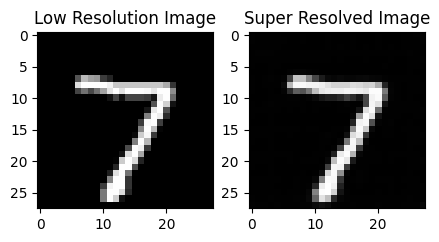

In [12]:
import torch.nn.functional as F

import torch.nn.functional as F

class ImprovedSuperResolutionAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1),  # Entrada: 1 canal, Salida: 64 canales, reduciendo las dimensiones
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # Salida: 128 canales, reduciendo las dimensiones
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),  # Salida: 256 canales, reduciendo las dimensiones
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # Salida: 128 canales, aumentando las dimensiones
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # Salida: 64 canales, aumentando las dimensiones
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=3, stride=1, padding=1),  # Salida: 1 canal
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Cambios en la función de pérdida y optimizador
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(super_resolution_model.parameters(), lr=1e-3, weight_decay=1e-4)  # Agregamos weight_decay para regularización L2

# Resto del código de entrenamiento...


num_epochs=5

for epoch in range(num_epochs):
    for (img, _) in data_loader:

        img = torch.clamp(img, 0., 1.)

        recon = super_resolution_model(img)


        loss = criterion(recon, img)


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')

with torch.no_grad():
    low_resolution_image, _ = data_loader_valid.dataset[0]
    low_resolution_image = low_resolution_image.unsqueeze(0)
    super_resolution_output = super_resolution_model(low_resolution_image)

plt.figure(figsize=(5, 5))
plt.subplot(1, 2, 1)
plt.imshow(low_resolution_image.squeeze().numpy(), cmap='gray')
plt.title('Low Resolution Image')

plt.subplot(1, 2, 2)
plt.imshow(super_resolution_output.squeeze().numpy(), cmap='gray')
plt.title('Super Resolved Image')

plt.show()
